In [0]:
#immporting library
import pandas as pd

from sklearn.model_selection import train_test_split

import numpy as np


Here are the first 10 rows of the dataset: 
   longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...            452600.0         NEAR BAY
1    -122.22     37.86  ...            358500.0         NEAR BAY
2    -122.24     37.85  ...            352100.0         NEAR BAY
3    -122.25     37.85  ...            341300.0         NEAR BAY
4    -122.25     37.85  ...            342200.0         NEAR BAY
5    -122.25     37.85  ...            269700.0         NEAR BAY
6    -122.25     37.84  ...            299200.0         NEAR BAY
7    -122.25     37.84  ...            241400.0         NEAR BAY
8    -122.26     37.84  ...            226700.0         NEAR BAY
9    -122.25     37.84  ...            261100.0         NEAR BAY

[10 rows x 10 columns]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f206132eda0>,
      dtype=object)

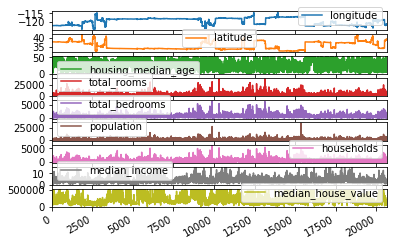

In [208]:
#below is the url for housing dataset (csv file)
url="https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv"

dataset=pd.read_csv(url) #reading data from url
#removing any incompelete part from dataset
dataset =dataset.dropna()
print("Here are the first 10 rows of the dataset: ")
gf = dataset.head(n =10)#getting first 10 rows from dataset
print (gf)#printing first 10 rows from dataset
dataset.plot(subplots=True)#ploting graph for dataset and putting subplots=True to get each feature on different subplot.

In [0]:
Y = dataset['median_house_value'] #we want to predict median_housing_value

X= dataset.loc[:,'longitude':'median_income'] #selecting column form logitute to median_income

In [0]:
# spliting dataset into 70% for training and 30% for testing and setting randon_state to 2003
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2003)
from sklearn.preprocessing import MinMaxScaler #importing MinMaxScaler for scaling purpose
ms = MinMaxScaler() 
x_train_np = ms.fit_transform(x_train)
y_train_np = y_train.to_numpy()

x_test_np = ms.transform(x_test)
y_test_np = y_test.to_numpy()


In [0]:
#importing pytorch library
import torch
#importing 1D convolution layer as we are inserting 1-D row of data 
from torch.nn import Conv1d
#importing Maxpooling layer
from torch.nn import MaxPool1d
#importing flatten layer
from torch.nn import Flatten
#importing linear layer
from torch.nn import Linear
#importing RELU activation function
from torch.nn.functional import relu

#importing DataLoader and TensorDataset Libarary to work with our dataset
from torch.utils.data import DataLoader, TensorDataset

In [0]:
# Student ID : 1100901, Name: Vashihstha Master
class _1100901_1dconv_reg(torch.nn.Module):
#defining initialization method
  def __init__(self, batch_size, inputs, outputs):
#initializing super class and store parameters
    super(_1100901_1dconv_reg, self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs
    #defining Convolutional layer kernel size=1
    self.input_layer = Conv1d(inputs, batch_size, 1)
    #defining Max pooling layer kernel size=1
    self.max_pooling_layer = MaxPool1d(1)
    #another 2 convolutional layers
    self.conv_layer = Conv1d(batch_size, 128, 1)
    self.conv_layer2 = Conv1d(128, 128, 1)
    #defining flatten layer
    self.flatten_layer = Flatten()
    #defining linear layer
    self.linear_layer = Linear(128, 64)
    #defining output layer
    self.output_layer = Linear(64, outputs)
#feed method to feed input to model
  def feed(self, input):
#reshape the entry to fed to input layer
    input = input.reshape((self.batch_size,self.inputs, 1))
#the relu activation function
    output = relu(self.input_layer(input))
   #Get the output of the maxpoolinglayer 
    output = self.max_pooling_layer(output)

    output = relu(self.conv_layer(output))

    output = relu(self.conv_layer2(output))

    output = self.flatten_layer(output)

    output = self.linear_layer(output)

    output = self.output_layer(output)
#finally getting output once passed from every layers and returing it.
    return output

In [203]:
from torch.optim import Adam #importing optimizer I am using Adam optimizer
#importing L1Loss our perfomance measure
from torch.nn import L1Loss
#Import the R^2 score package from pytorch's ignite for our score measure
#This package is not installed by default so the next line does that

!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

In [204]:
batch_size = 64 #batch size

model = _1100901_1dconv_reg(batch_size, X.shape[1],1)

model.cuda() #set model to use GPU for processing

_1100901_1dconv_reg(
  (input_layer): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (conv_layer2): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
def model_loss(model, dataset, train = False , optimizer = None):

  perfomance = L1Loss()
  score_metric = R2Score()

  avg_loss = 0
  avg_score = 0
  count = 0

  for input, output in iter(dataset):

    predictions = model.feed(input)

    loss= perfomance(predictions, output)
    score_metric.update([predictions,output])
    score = score_metric.compute()

    if(train):
      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

    avg_loss += loss.item()
    avg_score += score
    count += 1

  return avg_loss / count, avg_score / count

In [206]:
# I have used 300 epochs for training
epochs = 300 
#defining perfomance measure and optimizer
optimizer = Adam(model.parameters(), lr=1e-3)

inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0],1)).cuda().float()

tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)
#starting Training loop
for epoch in range(epochs):
  avg_loss, avg_r2_score = model_loss(model, loader, train = True, optimizer=optimizer)
#printing Loss and R^2 Score
  print("Epoch " + str(epoch + 1) + "\n\tLoss = " + str(avg_loss) + "\n\tR^2 Score = " + str(avg_r2_score))

Epoch 1
	Loss = 157801.74334360988
	R^2 Score = -2.8669686056719064
Epoch 2
	Loss = 81657.02949831838
	R^2 Score = 0.09542575797444329
Epoch 3
	Loss = 75895.11818595852
	R^2 Score = 0.19824470710761613
Epoch 4
	Loss = 64763.47787626121
	R^2 Score = 0.366419065676393
Epoch 5
	Loss = 55200.87340596973
	R^2 Score = 0.5230180932186428
Epoch 6
	Loss = 53576.69068806054
	R^2 Score = 0.5552906771174259
Epoch 7
	Loss = 52634.01961007567
	R^2 Score = 0.5548618937300267
Epoch 8
	Loss = 51830.27522421525
	R^2 Score = 0.5812196256103537
Epoch 9
	Loss = 51046.83394058296
	R^2 Score = 0.5829063580689144
Epoch 10
	Loss = 50283.980311098654
	R^2 Score = 0.5922204444941778
Epoch 11
	Loss = 49667.98723024103
	R^2 Score = 0.5904206300857566
Epoch 12
	Loss = 49002.913764714125
	R^2 Score = 0.5987191844340038
Epoch 13
	Loss = 48418.783141816144
	R^2 Score = 0.6178402684047326
Epoch 14
	Loss = 47813.20785454036
	R^2 Score = 0.6274520382523914
Epoch 15
	Loss = 47371.00714686099
	R^2 Score = 0.631636322497553

In [207]:
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0],1)).cuda().float()

tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
avg_loss, avg_r2_score = model_loss(model, loader)
end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

#printing average L1 Loss, average R^2 score and model's Inference Time
print("The model's L1 loss is:" + str(avg_loss))
print("The model's R^2 score is:" + str(avg_r2_score))
print("The model's Inference Time is:" + str(start.elapsed_time(end)))

The model's L1 loss is:35101.079420230264
The model's R^2 score is:0.7829888445436695
The model's Inference Time is:129.2972869873047
